In [1]:
%pylab inline
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqmodels import QLF_McGreer_2013

Populating the interactive namespace from numpy and matplotlib


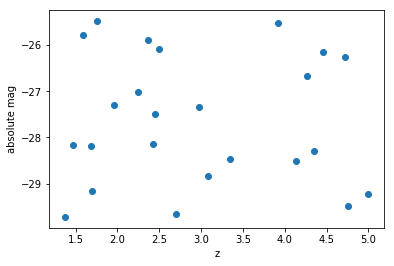

In [2]:
# set up a luminosity-redshift grid
M = AbsMagVar(UniformSampler(-30,-25),restWave=1450)
z = RedshiftVar(UniformSampler(1,5))
MzGrid = QsoSimGrid([M,z],(4,3),2)
scatter(MzGrid.z,MzGrid.absMag,)
xlabel('z')
ylabel('absolute mag')

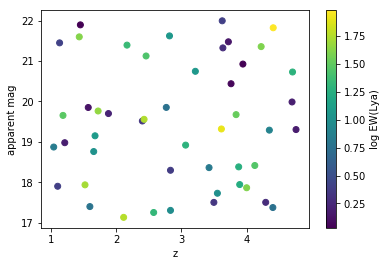

In [3]:
# set up a flux-redshift grid with Lya EW as a third dimension
m = AppMagVar(UniformSampler(17,22),'SDSS-i')
lya = GaussianLineEqWidthVar(UniformSampler(0,2),'LyaEW',1215.67,10.)
mzlyaGrid = QsoSimGrid([m,z,lya],(4,3,2),2)
scatter(mzlyaGrid.z,mzlyaGrid.appMag,c=mzlyaGrid.LyaEW)
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('log EW(Lya)')

In [4]:
# Generate m,z points by sampling from a model QLF
cosmo = QLF_McGreer_2013.cosmo
kcorr = lambda z: sqbase.continuum_kcorr('SDSS-i',1450,z)
m2M = lambda z: sqbase.mag2lum('SDSS-i',1450,z,cosmo)
m,z = generateQlfPoints(QLF_McGreer_2013,(17,22),(4.5,5.3),'SDSS-i',
                        kcorr=kcorr,skyArea=100)
qlfGrid = QsoSimPoints([m,z],cosmo=cosmo,units='flux')
qlfGrid.addVar(AbsMagVar(FixedSampler(qlfGrid.appMag-m2M(qlfGrid.z))))

integration returned  43  objects


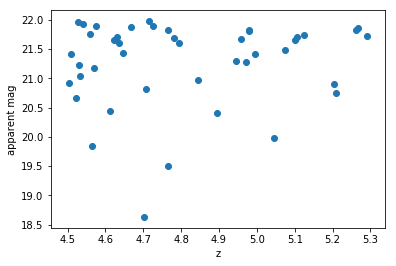

In [5]:
scatter(qlfGrid.z,qlfGrid.appMag)
xlabel('z')
ylabel('apparent mag')

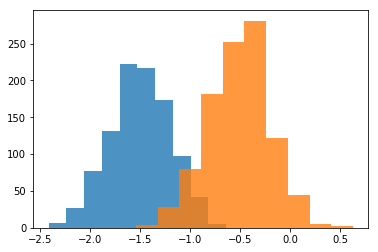

In [6]:
# test the canonical values for power law continuum slopes in FUV/NUV
contVar = BrokenPowerLawContinuumVar([GaussianSampler(-1.5,0.3),GaussianSampler(-0.5,0.3)],[1215.])
contVals = contVar(1000)
_ = hist(contVals[:,0],alpha=0.8)
_ = hist(contVals[:,1],alpha=0.8)

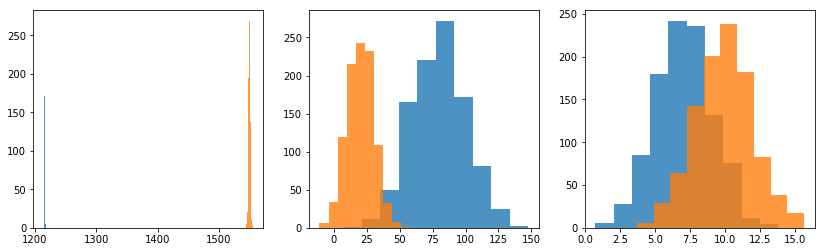

In [7]:
# Add gaussian emission lines
g = GaussianSampler
lya = [g(1215.7,0.5),g(80,20),g(7,2)]
civ = [g(1550.0,1.5),g(20,10),g(10,2)]
emLinesVar = GaussianEmissionLinesTemplateVar([lya,civ])
emLinesVals = emLinesVar(1000)
figure(figsize=(14,4))
for k in range(3):
    subplot(1,3,k+1)
    for j in range(2):
        hist(emLinesVals[:,j,k],alpha=0.8)

In [8]:
# add gaussian lines to the qlf grid
qlfGrid.addVar(emLinesVar)
print qlfGrid

    appMag          z           absMag             emLines [2,3]         
------------- ------------- -------------- ------------------------------
21.8876640234 4.57502949215 -24.4749066944 1215.75364328 .. 10.2536896808
20.9088340638  5.2030268263 -25.7255103741 1215.28577237 .. 9.72422000391
21.9251360248 4.54075435819  -24.421436716 1215.07063173 .. 12.5238324845
21.6090999698 4.63698246027 -24.7820551894 1215.51791806 .. 8.94568856743
19.5031211694 4.76635009766 -26.9463901492 1216.80975098 .. 7.42299216224
 21.491858768 5.07523736689 -25.0902161123 1215.72128807 .. 8.75821661967
21.7268383967 5.29024975332 -24.9423791903 1216.29387507 .. 8.24730175667
21.8884570159 4.72431149419 -24.5422844477 1216.47535915 .. 13.0610988764
21.1708585683  4.5707467494 -25.1897204033 1216.12100823 .. 11.9499533373
20.4451723451 4.61100869599 -25.9340503096  1216.0410498 .. 7.74116739679
          ...           ...            ...                            ...
 21.662715926 4.62348937652 -24.722249

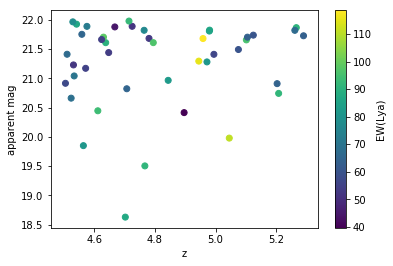

In [9]:
scatter(qlfGrid.z,qlfGrid.appMag,c=qlfGrid.emLines[:,0,1])
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('EW(Lya)')

In [10]:
# Now use the BOSS DR9 emission line template, including the Baldwin Effect
lineTemplate = generateBEffEmissionLines(qlfGrid.absMag)
lines = lineTemplate()
lines.shape

(43, 62, 3)

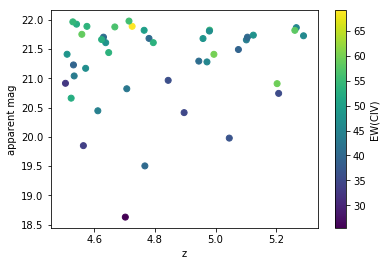

In [11]:
scatter(qlfGrid.z,qlfGrid.appMag,c=lines[:,13,1])
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('EW(CIV)')

In [12]:
vdblines = generateVdBCompositeEmLines(minEW=0)
vdblines = vdblines(qlfGrid.nObj)

using the following lines from VdB template:  Ly{epsilon},CIII,Ly{beta},ArI,FeIII,CIII*,Ly{alpha},NV,SiII,OI,CII,SiIV,CIV,HeII,OIII],NIV,NIII],FeII,SiII,AlIII,SiIII],CIII],FeIII,FeIII,FeII,FeII,FeII,CII],[NeIV],[OII],FeII,AlII],MgII,FeII,OIII,HeI,FeI,FeII,[NeV],[NeV],FeII,[FeVII],[OII],[FeVII],FeII,FeII,[NeIII],HeI,[NeIII],[FeV],H{delta},FeII,FeII,[FeII],[FeII],H{gamma},[OIII],FeII,FeII,HeII,H{beta},FeII,[OIII],[OIII],[FeVII],[FeVI],[NI],[FeVII],FeII,[FeXIV],[ClIII],[FeVII],HeI,[FeVII],[OI],[OI],[NII],H{alpha},[NII],[SII],[SII],HeI,[ArIII],[OII],[NiIII]


In [13]:
wave = arange(3000,1e4,0.5)
z = 2.0
def quick_spec(emlines):
    lineWave,eqWidth,sigma = emlines.T * (1+z)
    spec = np.zeros_like(wave)
    A = eqWidth/(np.sqrt(2*np.pi)*sigma)
    twosig2 = 2*sigma**2
    nsig = np.sqrt(-2*np.log(1e-3/A))
    nsig = (nsig*np.array([[-1.],[1]])).T
    for i in xrange(lineWave.shape[0]):
        i1,i2 = np.searchsorted(wave,lineWave[i]+nsig[i]*sigma[i])
        if i2 != i1:
            lineprofile = A[i]*np.exp(-(wave[i1:i2]-lineWave[i])**2
                                       / twosig2[i])
            spec[i1:i2] += lineprofile
    return spec

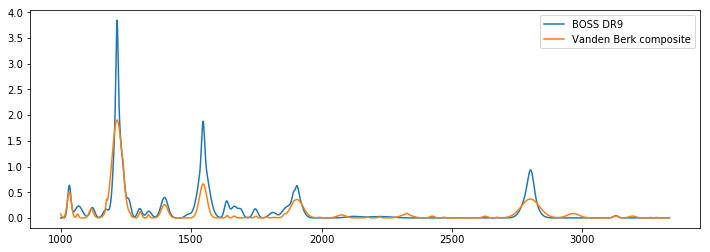

In [14]:
figure(figsize=(12,4))
plot(wave/(1+z),quick_spec(lines[0]),label='BOSS DR9')
plot(wave/(1+z),quick_spec(vdblines[0]),label='Vanden Berk composite')
legend()